# Assignment 2

To be delivered until 2022/01/24 23:59:59.

## 1) Arduino

You will start by setting up a series of connections in order to extract some data with the Arduino. First make the connections as shown below. **Mind the direction of the temperature sensor. If you have an incorrect position, you will be connection the power to the ground and vice-versa and you will damage the sensor.** The photoresistor sensor on the other hand has no polarity.

<img src="temp_photo_cropped.png" width=1000/>

On this problem, you will read temperature and luminance from the sensors and print them on the serial.

**1)** Code an Arduino sketch, where the value of temperature and luminance are printed to the serial. For each serial print that you make, print the value of temperature, then a semicolon, then the value of luminance with a new line (use no whitespaces). You can do this by using three separate `Serial.print`, with the last one being a `Serial.println`. Print values 5 times per second (use the delay function to control this). Manually influence the readings of the sensors, by covering the photoresistor or shining light on it, and by lightly and carefully touching the temperature sensor to increase its temperature readings.

**Note that the temperature sensor appears not to be very reliable. Since the objective of this exercise is just to plot the results, this should not be an issue.**

**Copy and paste your arduino code below. You may use a python code cell, even though the code can not be run.**

*Hint: for the temperature value to be in celsius, divide the read value by 1024 and multiply it by 500. The luminance does not have to be converted*

In [ ]:
float temp;
float lum;
int lumPin = 0;
int tempPin = 1;

void setup() {
   Serial.begin(9600);
}

void loop() {
  
   lum = analogRead(lumPin);
   // leitura do valor do sensor e salvar na variavel lum
   temp = analogRead(tempPin);
   // leitura do valor do sensor e salvar na variavel lum temp
   temp = (temp/1024) * 500;
   // converter o valor analógico em volt para o seu equivalente em ºC
   Serial.print(lum); // Mostrar os valor da luminosidade
   Serial.print(';');
   Serial.print(temp); // Mostrar o valor da Temperatura
   Serial.println();
   delay(200); // Realização de 5 leituras a cada segundo
}

To import the data into Arduino, keep it running (the Serial Monitor must be closed in Arduino) and run the following code. Change the COM port to your own. This block of code will read 1000 values from the Serial. Given that each observation is taken every 0.2 seconds, it should take a minute and a half.

In [28]:
import serial
import time

ser = serial.Serial('COM4', 9600, timeout=1)
time.sleep(2)

data = []
for i in range(500):
    line = ser.readline()
    if line:
        string = line.decode()
        data.append(string)

ser.close()

Convert the data into a pandas dataframe and save it in a csv file. Besides the value of temperature and luminance, also include the time, considering the first observation at $t=0$ and every observation 0.2 seconds after the previous one. **The file must be submitted in Fenix and included in your Github repo**.

In [1]:
import pandas as pd

# Converter os dados obtidos do laboratório para csv
data.to_csv('Lab4.csv', index=False)

# Converção dos dados para pandas dataframe
data = pd.read_csv ('Lab4.csv')

# Tratamentos dos dados
data_split = data["0"].str.split("\n",n=1, expand = True) # Retirar os valores \n dos dados de forma a ficar apenas com os valores da temperatura
data_split.columns = ['lum','Temp']
data_split1 = data_split.drop(columns = ['Temp']) 
data_lab = data_split1['lum'].str.split(";",n=1, expand = True) # Divisão dos dados em luminosidade e temperatura
data_lab.columns = ['Luminosidade','Temperatura']

# Criação do tempo com intervalo de 0.2 segundos
time = [x*0.2 for x in range(0,len(data))]
data_lab.insert(0, "Tempo", time, True)

# Converter os valores da temperatura e luminosidade para float
data_lab['Luminosidade'] = data_lab['Luminosidade'].astype(float, errors = 'raise')
data_lab['Temperatura'] = data_lab['Temperatura'].astype(float, errors = 'raise')

# Guardar os dados após o tratamento num ficheiro csv

data_lab.to_csv('Dados Lab 4.csv', index=False)


data_lab.head()

,Tempo,Luminosidade,Temperatura
0,0.0,549.0,19.0
1,0.2,549.0,18.0
2,0.4,549.0,18.0
3,0.6,548.0,19.0
4,0.8,548.0,19.0


Plot the Temperature against time, the luminance against time and the temperature against the luminance.

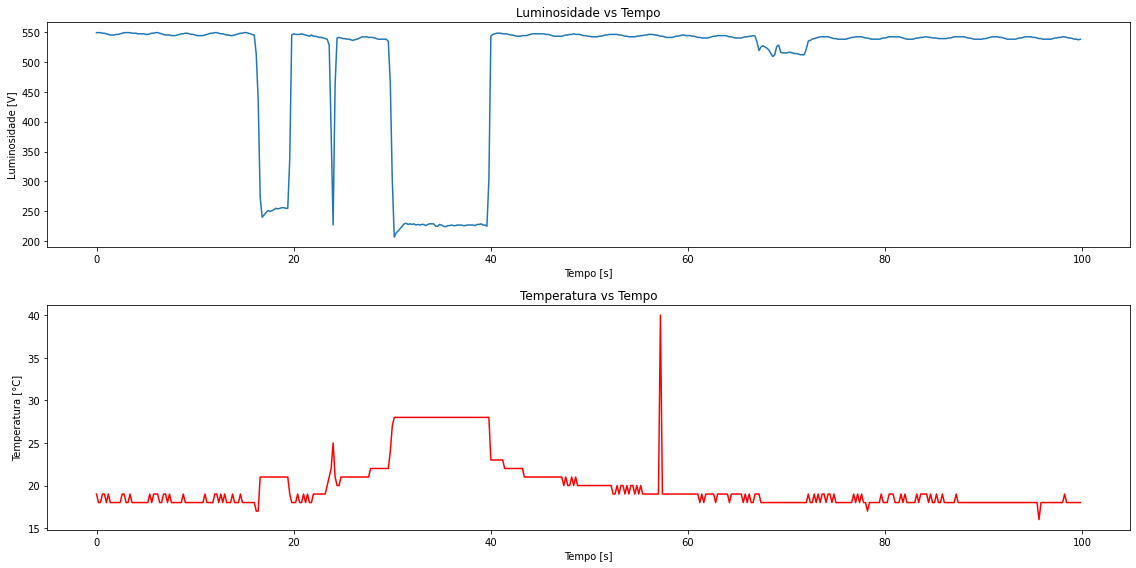

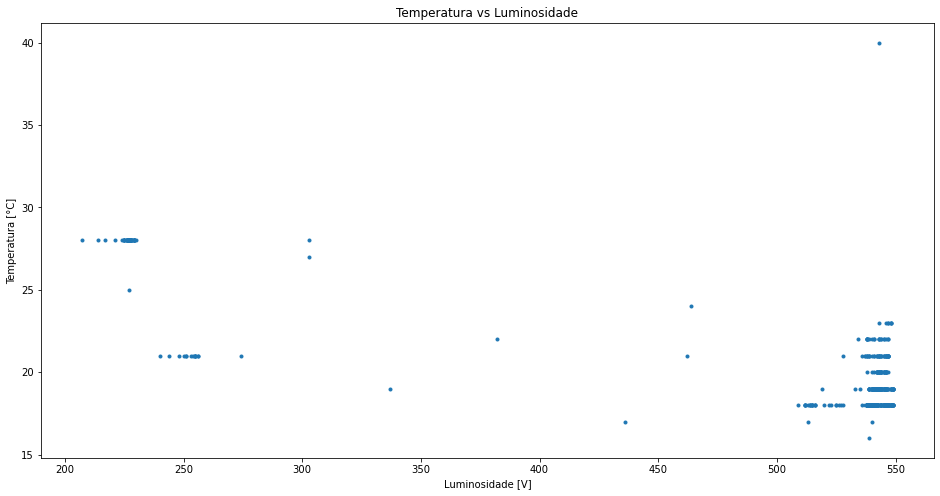

In [2]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [16, 8]

# Gráfico Luminosidade vs Tempo
plt.figure()
plt.subplot(211)
plt.title('Luminosidade vs Tempo')
plt.ylabel('Luminosidade [V]')
plt.xlabel('Tempo [s]')
plt.plot(data_lab['Tempo'],data_lab['Luminosidade'])

# Gráfico Temperatura vs Tempo
plt.subplot(212)
plt.title('Temperatura vs Tempo')
plt.ylabel('Temperatura [°C]')
plt.xlabel('Tempo [s]')
plt.tight_layout()
plt.plot(data_lab['Tempo'],data_lab['Temperatura'], 'r')
plt.show()

# Gráfico da Temperatura vs Luminosidade
plt.figure()
plt.title('Temperatura vs Luminosidade')
plt.xlabel('Luminosidade [V]')
plt.ylabel('Temperatura [°C]')
plt.scatter(data_lab['Luminosidade'],data_lab['Temperatura'], marker= '.')

## 2) Databases

For the databases part of this assignment, you will use the mimic-iii database from the laboratory session. Start by adding a few new tables to the database, using the SQL files included in the assignment's files. Open PGAdmin and connect to your mimic-iii database. **To properly load these tables, load the following files exactly and by the order presented.**

1) Run demographic.sql

2) Run lab_firstday.sql

You will now have to answer a few SQL questions.

**1.** Open the connection to your mimic-iii database. If you want, you can delete your credentials before submitting the assignment, but if you do so, please run the notebook first, for the results to be displayed.

In [1]:
import pandas as pd
import numpy as np
import psycopg2 as psql
import matplotlib.pyplot as plt

conn = psql.connect(host='localhost',
                    database='mimic-iii',
                    user='username',
                    password='password',
                    port=5432)

cursor = conn.cursor()
cursor.execute("select version()")
data = cursor.fetchone()

print("Connection established to: ", data)

Connection established to:  ('PostgreSQL 14.1, compiled by Visual C++ build 1914, 64-bit',)


**2.** Create a function that receives an SQL query and automatically opens a cursor, queries the database, extracts the columns, creates a pandas database, and closes the connections.

In [6]:
import pandas as pd
import psycopg2 as psql
def receive_query( query ):
    cursor = conn.cursor()
    cursor.execute(query)
    colnames = [desc[0] for desc in cursor.description]
    data = cursor.fetchall()
    query_table = pd.DataFrame(data, columns = colnames)
    print(query_table)
    conn.close()
    return

**3.** Query the table admissions filtering for admission type as elective and insurance as private.

In [2]:
filtering = "SELECT * FROM public.admissions WHERE admission_type = 'ELECTIVE' AND insurance = 'Private'"
cursor.execute(filtering)

colnames = [desc[0] for desc in cursor.description]
data = cursor.fetchall()



filtered_table = pd.DataFrame(data, columns = colnames)
filtered_table

,row_id,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,language,religion,marital_status,ethnicity,edregtime,edouttime,diagnosis,hospital_expire_flag,has_chartevents_data
0,12315,10065,183314,2189-09-08 07:15:00,2189-09-20 14:00:00,None,ELECTIVE,PHYS REFERRAL/NORMAL DELI,SNF,Private,ENGL,CATHOLIC,SINGLE,WHITE,None,None,ESOPHAGEAL CANCER/SDA,0,1
1,40972,43798,130870,2198-06-29 07:15:00,2198-08-07 23:59:00,None,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Private,ENGL,CATHOLIC,MARRIED,WHITE,None,None,ESOPHAGEAL CA/SDA,0,1
2,41053,44083,125157,2112-05-04 08:00:00,2112-05-11 14:15:00,None,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Private,ENGL,CATHOLIC,SINGLE,WHITE,None,None,ESOPHAGEAL CA/SDA,0,1


**4.** Query the table admissions, filtering for the same conditions as the previous exercise (admission type as elective and insurance as private). Join the "drgcodes" table on the admission ID. Display only the columns regarding the subject id, admission id, time of death, and description of the drug.

In [3]:
joined = "SELECT admissions.subject_id, admissions.hadm_id as admission_type, deathtime, drgcodes.description FROM admissions LEFT JOIN drgcodes ON admissions.hadm_id = drgcodes.hadm_id WHERE insurance = 'Private' and admission_type = 'ELECTIVE';"
cursor.execute(joined)

colnames = [desc[0] for desc in cursor.description]
data2 = cursor.fetchall()


joined_table = pd.DataFrame(data2, columns = colnames)
joined_table

,subject_id,admission_type,deathtime,description
0,10065,183314,None,"Major Stomach, Esophageal & Duodenal Procedures"
1,10065,183314,None,"STOMACH, ESOPHAGEAL & DUODENAL PROC AGE >17 W ..."
2,43798,130870,None,Tracheostomy W Long Term Mechanical Ventilatio...
3,43798,130870,None,Tracheostomy W Long Term Mechanical Ventilatio...
4,43798,130870,None,"TRACH W MV 96+ HRS OR PDX EXC FACE, MOUTH & NE..."
5,44083,125157,None,"Major Stomach, Esophageal & Duodenal Procedures"
6,44083,125157,None,"Major Stomach, Esophageal & Duodenal Procedures"
7,44083,125157,None,"STOMACH, ESOPHAGEAL & DUODENAL PROC W MCC"


**5.1.** Obtain the dataset for this problem, by running the SQL query below.

In [4]:
dataset = "SELECT pivoted_lab.*," +\
                "gender as gender," +\
                "admission_age," +\
                "ethnicity_grouped as eth_grp," +\
                "hospital_expire_flag," +\
                "los_icu " +\
        "FROM demographics " +\
        "LEFT JOIN pivoted_lab " +\
        "ON demographics.icustay_id = pivoted_lab.icustay_id " +\
        "WHERE first_icu_stay = true"
cursor.execute(dataset)

colnames = [desc[0] for desc in cursor.description]
data3 = cursor.fetchall()


dataset_table = pd.DataFrame(data3, columns = colnames)
dataset_table

,subject_id,hadm_id,icustay_id,aniongap_min,aniongap_max,albumin_min,albumin_max,bands_min,bands_max,bicarbonate_min,...,sodium_max,bun_min,bun_max,wbc_min,wbc_max,gender,admission_age,eth_grp,hospital_expire_flag,los_icu
0,10006,142345,206504,12.0,20.0,2.7,3.4,NaN,NaN,29.0,...,139.0,9.0,11.0,4.6,7.8,F,70.0,black,0,1.0
1,10011,105331,232110,12.0,12.0,2.6,2.6,2.0,2.0,23.0,...,136.0,3.0,3.0,10.6,10.6,F,36.0,unknown,1,13.0
2,10013,165520,264446,13.0,13.0,NaN,NaN,13.0,13.0,29.0,...,138.0,32.0,32.0,13.8,16.2,F,87.0,unknown,1,2.0
3,10017,199207,204881,13.0,13.0,2.8,2.8,NaN,NaN,29.0,...,139.0,3.0,3.0,15.8,15.8,F,74.0,white,0,2.0
4,10019,177759,228977,20.0,46.0,3.2,3.2,NaN,NaN,10.0,...,141.0,31.0,53.0,3.7,6.8,M,49.0,white,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,44083,198330,286428,16.0,16.0,NaN,NaN,NaN,NaN,21.0,...,142.0,12.0,12.0,12.3,14.9,M,55.0,white,0,3.0
124,44154,174245,217724,15.0,15.0,NaN,NaN,NaN,NaN,19.0,...,142.0,16.0,21.0,12.2,17.1,M,300.0,white,1,0.0
125,44212,163189,239396,15.0,21.0,2.9,3.0,NaN,NaN,18.0,...,150.0,37.0,57.0,8.8,11.4,F,45.0,black,0,31.0
126,44222,192189,238186,11.0,15.0,NaN,NaN,NaN,NaN,22.0,...,135.0,21.0,24.0,9.3,9.9,M,73.0,white,0,1.0


**5.2.** Close the connection to your SQL server.

In [7]:
conn.close()

**5.3.** Prepare your dataset:

* Drop the ID columns of subject, admission and ICU stay.
* Drop columns with at least one NA value.
* Encode the categorical columns, the ethnicity and gender ('eth_grp', 'gender'). *Suggestion: use pd.get_dummies*

In [5]:
dummies = pd.get_dummies(dataset_table[['eth_grp', 'gender']])
dataset_table = pd.concat([dataset_table, dummies[['eth_grp_asian', 'eth_grp_black' ,'eth_grp_hispanic', 'eth_grp_native', 'eth_grp_other', 'eth_grp_unknown', 'eth_grp_white', 'gender_F', 'gender_M']]], axis=1)
dataset_table.drop(['subject_id', 'hadm_id', 'icustay_id','eth_grp', 'gender'], inplace=True, axis=1)
dataset_table = dataset_table.dropna(axis='columns')
dataset_table

,bicarbonate_min,bicarbonate_max,creatinine_min,creatinine_max,chloride_min,chloride_max,glucose_min,glucose_max,hematocrit_min,hematocrit_max,...,los_icu,eth_grp_asian,eth_grp_black,eth_grp_hispanic,eth_grp_native,eth_grp_other,eth_grp_unknown,eth_grp_white,gender_F,gender_M
0,29.0,31.0,3.0,3.5,96.0,100.0,84.0,217.0,36.9,42.4,...,1.0,0,1,0,0,0,0,0,1,0
1,23.0,23.0,0.7,0.7,107.0,107.0,79.0,79.0,33.9,34.0,...,13.0,0,0,0,0,0,1,0,1,0
2,29.0,29.0,1.7,1.7,98.0,100.0,134.0,165.0,28.1,29.2,...,2.0,0,0,0,0,0,1,0,1,0
3,29.0,29.0,0.3,0.3,100.0,100.0,137.0,137.0,27.5,27.5,...,2.0,0,0,0,0,0,0,1,1,0
4,10.0,18.0,4.0,7.2,83.0,104.0,80.0,360.0,30.6,36.0,...,1.0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,21.0,21.0,0.7,0.7,108.0,108.0,151.0,151.0,26.0,29.0,...,3.0,0,0,0,0,0,0,1,0,1
124,19.0,19.0,0.9,0.9,107.0,113.0,164.0,177.0,40.8,41.8,...,0.0,0,0,0,0,0,0,1,0,1
125,18.0,23.0,3.0,4.8,108.0,115.0,99.0,122.0,23.8,25.9,...,31.0,0,1,0,0,0,0,0,1,0
126,22.0,27.0,1.2,1.7,100.0,101.0,56.0,268.0,37.8,39.0,...,1.0,0,0,0,0,0,0,1,0,1


**6.** Fit the following tree-based classifiers to the dataset. For each method:

* Perform k-fold cross validation to evaluate the models. Consider 10 folds.

* Plot the ROC curves for each fold, along with the mean ROC curve.

* Calculate the mean AUC.

**a.** Decision tree.

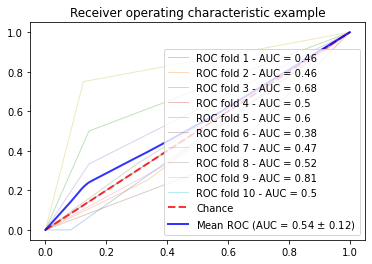

Mean AUC = 0.5367189925844655


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.metrics import confusion_matrix, mean_squared_error, auc, roc_curve
dataset = pd.read_csv('dataset_table.csv')
cols= ['Unnamed: 0','bicarbonate_min','bicarbonate_max','creatinine_min','creatinine_max', 'chloride_min','chloride_max','glucose_min','glucose_max','hematocrit_min','hematocrit_max','platelet_min','platelet_max','potassium_min','potassium_max','sodium_min','sodium_max','bun_min','bun_max','wbc_min','wbc_max','admission_age','los_icu','eth_grp_asian','eth_grp_black','eth_grp_hispanic','eth_grp_native','eth_grp_other','eth_grp_unknown','eth_grp_white','gender_F','gender_M','hospital_expire_flag']
dataset = dataset[cols] 
X = dataset.iloc[:, 1:-1]
y = dataset.iloc[:, -1]

from sklearn.model_selection import train_test_split, KFold
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 0)

from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
classifier.fit(X_train, y_train)
seed= 0

kfold = KFold(n_splits=10, shuffle=True, random_state=seed)

clf_rfc = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)

tprs = []
aucs = []

mean_fpr = np.linspace(0,1,100)

fig, ax = plt.subplots()

for i, (train,test) in enumerate(kfold.split(X,y)):
    clf_rfc.fit(X.loc[train], y[train])
    y_proba = clf_rfc.predict_proba(X.loc[test]) 
    fpr, tpr, _ = roc_curve(y[test], y_proba[:,1])
    
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    
    tprs.append(interp_tpr)
    aucs.append(auc(fpr,tpr))
    
    ax.plot(
        fpr, tpr,
        label='ROC fold ' + str(i+1) +  ' - AUC = ' + str(np.round(auc(fpr,tpr),2)),
        lw=1,
        alpha=0.3)

ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

# Plot mean roc curve auc
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title="Receiver operating characteristic example",
)

ax.legend(loc="lower right")
plt.rcParams['figure.figsize'] = [15, 6]
plt.show()
print('Mean AUC = ' + str(mean_auc))

In [3]:
from sklearn.metrics import confusion_matrix, accuracy_score
y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

[[22  6]
 [ 6  5]]


0.6923076923076923

**b.** Random forest

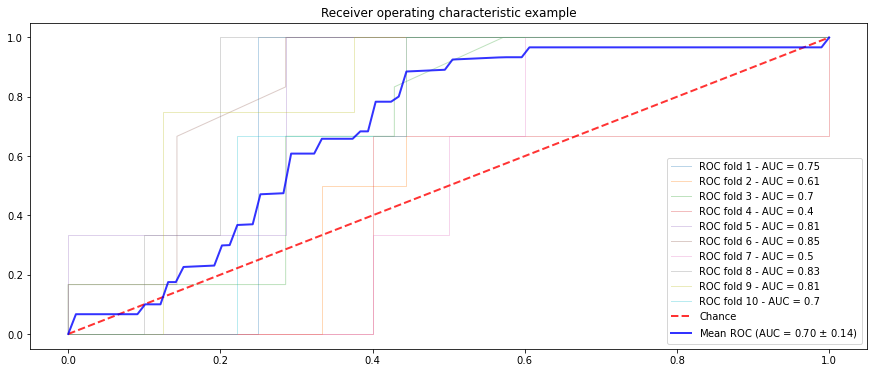

Mean AUC = 0.6976065367479508


In [4]:
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
classifier.fit(X_train, y_train)

kfold = KFold(n_splits=10, shuffle=True, random_state=seed)

# Random Forest Classifier
clf_rfc = RandomForestClassifier(n_estimators=200, random_state=seed)


tprs = []
aucs = []

mean_fpr = np.linspace(0,1,100)

fig, ax = plt.subplots()

for i, (train,test) in enumerate(kfold.split(X,y)):
    clf_rfc.fit(X.loc[train], y[train])
    y_proba = clf_rfc.predict_proba(X.loc[test]) 
    fpr, tpr, _ = roc_curve(y[test], y_proba[:,1])
    
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    
    tprs.append(interp_tpr)
    aucs.append(auc(fpr,tpr))
    
    ax.plot(
        fpr, tpr,
        label='ROC fold ' + str(i+1) +  ' - AUC = ' + str(np.round(auc(fpr,tpr),2)),
        lw=1,
        alpha=0.3)

ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

# Plot mean roc curve auc
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title="Receiver operating characteristic example",
)

ax.legend(loc="lower right")
plt.rcParams['figure.figsize'] = [15, 6]
plt.show()
print('Mean AUC = ' + str(mean_auc))

In [5]:
y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

[[25  3]
 [ 8  3]]


0.717948717948718

**c.** Gradient Boosting

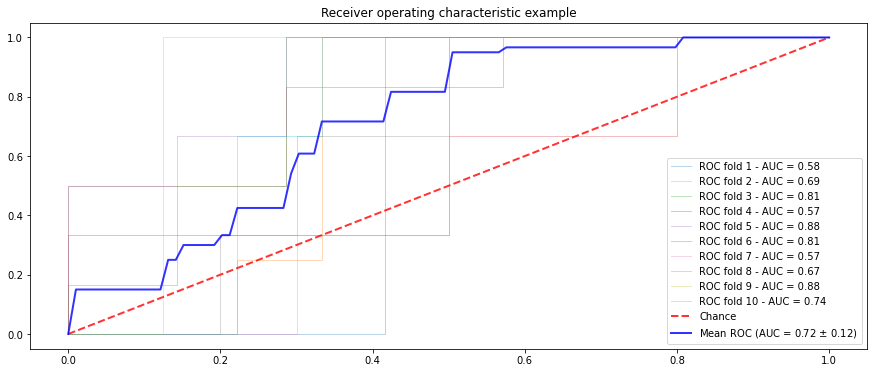

Mean AUC = 0.718939393939394


In [6]:
classifier = GradientBoostingClassifier(n_estimators = 500, learning_rate = 0.01, max_depth = 2, random_state = 1)
classifier.fit(X_train, y_train)

kfold = KFold(n_splits=10, shuffle=True, random_state=seed)

clf_rfc = GradientBoostingClassifier(n_estimators = 500, learning_rate = 0.01, max_depth = 2, random_state = 1)

tprs = []
aucs = []

mean_fpr = np.linspace(0,1,100)

fig, ax = plt.subplots()

for i, (train,test) in enumerate(kfold.split(X,y)):
    clf_rfc.fit(X.loc[train], y[train])
    y_proba = clf_rfc.predict_proba(X.loc[test]) 
    fpr, tpr, _ = roc_curve(y[test], y_proba[:,1])
    
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    
    tprs.append(interp_tpr)
    aucs.append(auc(fpr,tpr))
    
    ax.plot(
        fpr, tpr,
        label='ROC fold ' + str(i+1) +  ' - AUC = ' + str(np.round(auc(fpr,tpr),2)),
        lw=1,
        alpha=0.3)

ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

# Plot mean roc curve auc
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title="Receiver operating characteristic example",
)

ax.legend(loc="lower right")
plt.rcParams['figure.figsize'] = [15, 6]
plt.show()
print('Mean AUC = ' + str(mean_auc))

In [7]:
y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

[[24  4]
 [ 8  3]]


0.6923076923076923

**7.1.** Perform a grid search cross-validation on the Gradient boosting methods, changing the value of the learning rate (0.01 to 0.5) and the number of estimators (50-500). Consider the mean AUC of the folds as the performance measure.

In [8]:
from sklearn.model_selection import GridSearchCV
tuned_parameters = [{'learning_rate': [0.01, 0.1, 0.2, 0.3, 0.40, 0.5], 'n_estimators' : [50, 100, 200, 300, 400, 500]}]
clf = GridSearchCV(GradientBoostingClassifier(), tuned_parameters, cv=10, refit = 'roc_auc', scoring=['roc_auc'])
clf.fit(X_train,y_train)

GridSearchCV(cv=10, estimator=GradientBoostingClassifier(),
             param_grid=[{'learning_rate': [0.01, 0.1, 0.2, 0.3, 0.4, 0.5],
                          'n_estimators': [50, 100, 200, 300, 400, 500]}],
             refit='roc_auc', scoring=['roc_auc'])

In [9]:
print('Best parameters : ' + str(clf.best_params_))
bestlr = clf.best_params_.get("learning_rate")
bestnt = clf.best_params_.get("n_estimators")

Best parameters : {'learning_rate': 0.4, 'n_estimators': 50}


In [10]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFECV
rfecv = RFECV(estimator=classifier, 
              step=1, 
              cv=5, 
              scoring = 'roc_auc')
rfecv.fit(X,y)
pipeline  = Pipeline([('feature_sele',rfecv),
                      ('clf_cv',clf)])

pipeline.fit(X_train, y_train)
pipeline.predict(X_test)

print("Optimal number of features : %d" % rfecv.n_features_)

/Users/luislopes/opt/anaconda3/envs/bootcamp/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RFECV was fitted with feature names
  warnings.warn(
/Users/luislopes/opt/anaconda3/envs/bootcamp/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RFECV was fitted with feature names
  warnings.warn(


Optimal number of features : 30


In [11]:
features=list(X.columns[rfecv.support_])
print(features)

['bicarbonate_min', 'bicarbonate_max', 'creatinine_min', 'creatinine_max', 'chloride_min', 'chloride_max', 'glucose_min', 'glucose_max', 'hematocrit_min', 'hematocrit_max', 'platelet_min', 'platelet_max', 'potassium_min', 'potassium_max', 'sodium_min', 'sodium_max', 'bun_min', 'bun_max', 'wbc_min', 'wbc_max', 'admission_age', 'los_icu', 'eth_grp_asian', 'eth_grp_hispanic', 'eth_grp_native', 'eth_grp_other', 'eth_grp_unknown', 'eth_grp_white', 'gender_F', 'gender_M']


**7.2.** Plot a scatterplot of the learning rate versus the number of estimators, with the mean AUC as the color gradient.

In [12]:
kfold = KFold(n_splits=10, shuffle=True, random_state=seed)
estimators = [50, 100, 200, 300, 400, 500]
learningrate = [0.01, 0.1, 0.2, 0.3, 0.40, 0.5]  
m_auc = []

for e in range(0,6,1):
    for l in range(0,6,1):
     
        clf_rfc = GradientBoostingClassifier(n_estimators = estimators[e], learning_rate = learningrate[l], max_depth = 2, random_state = 1) 
        tprs = []
        aucs = []

        mean_fpr = np.linspace(0,1,100)

        for i, (train,test) in enumerate(kfold.split(X,y)):
            clf_rfc.fit(X.loc[train], y[train]) 
            y_proba = clf_rfc.predict_proba(X.loc[test]) 
            fpr, tpr, _ = roc_curve(y[test], y_proba[:,1])

            interp_tpr = np.interp(mean_fpr, fpr, tpr)
            interp_tpr[0] = 0.0

            tprs.append(interp_tpr)
            aucs.append(auc(fpr,tpr))

        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)
        
        m_auc.append(mean_auc)       

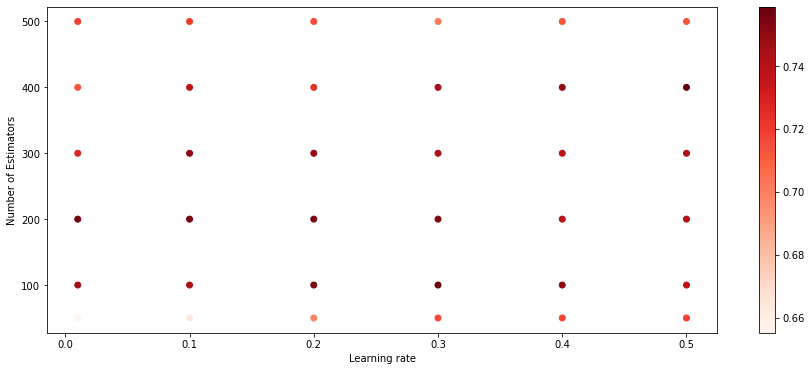

In [13]:
cv_results = pd.DataFrame(clf.cv_results_)
plt.scatter(cv_results['param_learning_rate'], cv_results['param_n_estimators'], c = m_auc, cmap = 'Reds')
cbar = plt.colorbar(orientation='vertical')
plt.xlabel('Learning rate')
plt.ylabel('Number of Estimators')
plt.show()

**8.1.** Perform forward stepwise selection on the dataset. Use the best parameters of the gradient boosting method obtained in **7.1.**.

In [14]:
clf8 = GradientBoostingClassifier(n_estimators = bestnt, learning_rate = bestlr, max_depth = 2, random_state = 1)
clf8.fit(X_train,y_train)

GradientBoostingClassifier(learning_rate=0.4, max_depth=2, n_estimators=50,
                           random_state=1)

In [15]:
import statsmodels.api as sm
models_best_forward = pd.DataFrame(columns=['k', "features", "rsq", "rss", "adjr2", 'aic', 'bic'])

predictors = []

for k in range(1, X.shape[1] + 1):
    print('Iterating for {}/{} features.'.format(k, X.shape[1]))
    remaining_predictors = [p for p in X.columns if p not in predictors]
    models_best_forward_iter = pd.DataFrame(columns=['feature_single', "features", "rsq", "rss", "adjr2", 'aic', 'bic'])
    count = 0
    for p in remaining_predictors:
        combo = predictors + [p]
        iter_X = X[combo]
        model = sm.OLS(y,sm.add_constant(iter_X)).fit()

    #        y_pred = regr.predict(iter_X)
        iter_vals = [
            p,
            ', '.join(combo),
            model.rsquared,      # rsq
            sum(model.resid**2), # rss
            model.rsquared_adj,  # adjr2
            model.aic,           # aic
            model.bic            # bic
        ]
        models_best_forward_iter.loc[count] = pd.DataFrame(
            [iter_vals],
            columns = ['feature_single', "features", "rsq", "rss", "adjr2", 'aic', 'bic']
        ).iloc[0,]
        count += 1

    predictors.append(models_best_forward_iter.loc[models_best_forward_iter['rsq'].argmax()]['feature_single'])
    
    models_best_forward_iter = models_best_forward_iter.rename(columns={"feature_single": "k"})
    models_best_forward_iter['k'] = k
    models_best_forward = models_best_forward.append(models_best_forward_iter)
    
models_best_forward

Iterating for 1/31 features.
Iterating for 2/31 features.
Iterating for 3/31 features.
Iterating for 4/31 features.
Iterating for 5/31 features.
Iterating for 6/31 features.
Iterating for 7/31 features.
Iterating for 8/31 features.
Iterating for 9/31 features.
Iterating for 10/31 features.
Iterating for 11/31 features.
Iterating for 12/31 features.
Iterating for 13/31 features.
Iterating for 14/31 features.
Iterating for 15/31 features.
Iterating for 16/31 features.
Iterating for 17/31 features.
Iterating for 18/31 features.
Iterating for 19/31 features.
Iterating for 20/31 features.
Iterating for 21/31 features.
Iterating for 22/31 features.
Iterating for 23/31 features.
Iterating for 24/31 features.
Iterating for 25/31 features.
Iterating for 26/31 features.
Iterating for 27/31 features.
Iterating for 28/31 features.
Iterating for 29/31 features.
Iterating for 30/31 features.
Iterating for 31/31 features.


,k,features,rsq,rss,adjr2,aic,bic
0,1,bicarbonate_min,2.845546e-02,26.345556,0.020745,164.914738,170.618799
1,1,bicarbonate_max,3.540512e-02,26.157100,0.027750,163.995836,169.699897
2,1,creatinine_min,1.258294e-02,26.775974,0.004746,166.989028,172.693088
3,1,creatinine_max,4.783308e-03,26.987478,-0.003115,167.996131,173.700191
4,1,chloride_min,9.774513e-07,27.117161,-0.007936,168.609738,174.313798
...,...,...,...,...,...,...,...
1,29,"eth_grp_hispanic, wbc_min, glucose_min, bicarb...",2.503984e-01,20.327086,0.038390,185.718541,268.427419
2,29,"eth_grp_hispanic, wbc_min, glucose_min, bicarb...",2.503984e-01,20.327086,0.038390,185.718541,268.427419
0,30,"eth_grp_hispanic, wbc_min, glucose_min, bicarb...",2.504128e-01,20.326697,0.028596,187.716091,273.276998
1,30,"eth_grp_hispanic, wbc_min, glucose_min, bicarb...",2.504128e-01,20.326697,0.028596,187.716091,273.276998


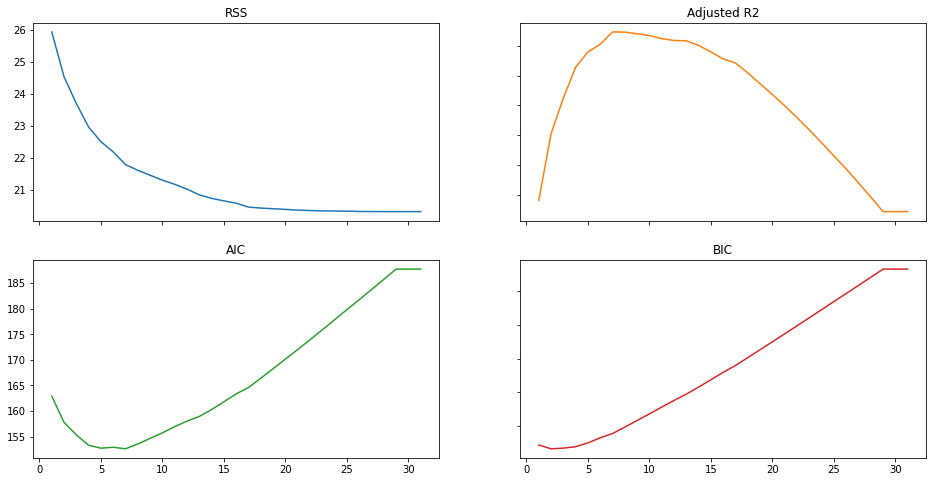

In [16]:
models_best3 = models_best_forward.copy()
models_best3 = models_best3[models_best3['rsq'] == models_best3.groupby('k')['rsq'].transform('max')]
models_best3 = models_best3.sort_values(by = 'k')

plt.rcParams["figure.figsize"] = (16,8)
fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(models_best3.k, models_best3.rss)
axs[0, 0].set_title('RSS')
axs[0, 1].plot(models_best3.k, models_best3.adjr2, 'tab:orange')
axs[0, 1].set_title('Adjusted R2')
axs[1, 0].plot(models_best3.k, models_best3.aic, 'tab:green')
axs[1, 0].set_title('AIC')
axs[1, 1].plot(models_best3.k, models_best3.bic, 'tab:red')
axs[1, 1].set_title('BIC')

for ax in axs.flat:
    ax.label_outer()

plt.show()

**8.2.** Compare and comment the results from **8.1.** with the features importance obtained through the grid search of queastion **7.1.**.

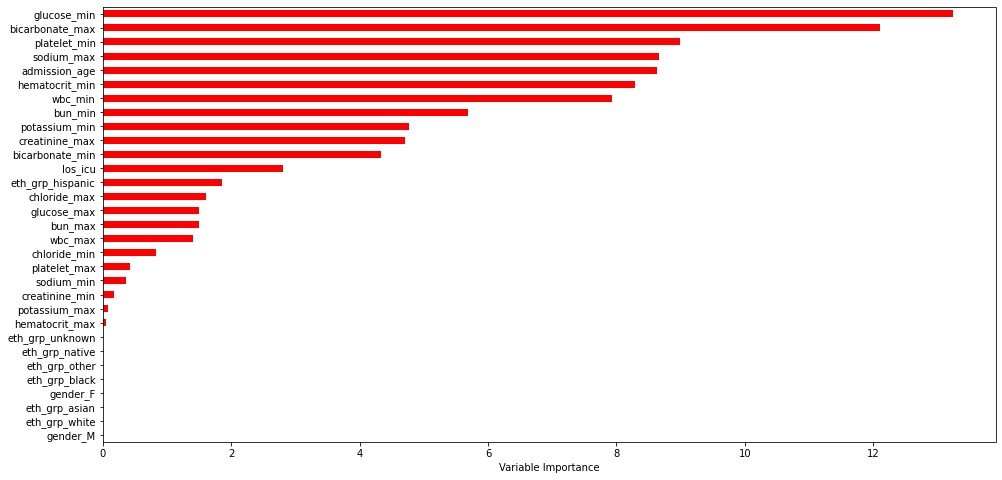

In [17]:
feature_importance = clf8.feature_importances_*100

rel_imp = pd.Series(feature_importance, index = X.columns).sort_values(inplace = False)

rel_imp.T.plot(kind = 'barh', 
               color = 'r', )

plt.xlabel('Variable Importance')

plt.gca().legend_ = None

It can be seen that while the RSS consistently reduces, the remaining scores are the best for about 6 features. This shows that using all features may not always provide the best model. From the graphic above we can also verify that there are some useless features with no importance value to the model.

## 3) Theoretical Questions

**1.** Consider a dataset where best subset, forward stepwise and backward stepwise selection will be performed. For each of the 3 approaches, we obtain $p+1$ models, $p$ being the total number of predictors. This means that each approach has a model with 0 predictors, one with 1 predictor, one with 2 predictor, up until one model with $p$ predictors. Answer and justify the following questions:

**a)** Which of the three models with $k, \, \forall_{k \in [0,p]}$ predictors has the smallest training RSS?

O método com o menor training RSS é o best subset visto que considera todas as hipóteses, porém, pode acontecer que os outros métodos escolham o mesmo modelo.

**b)** Which of the three models with $k, \, \forall_{k \in [0,p]}$ predictors has the smallest test RSS?

É díficil de prever.
É possível que no best subset haja overfitting e pode acontecer que o modelo escolhido pelos outros métodos tenham melhor desempenho no teste.

**c)** Evaluate the following statements with *true* or *false*. Justify your answers.

    i. The predictors in the k-variable model identified by forward stepwise selection are a subset of the predictors in the (k+1)-variable model identified by forward stepwise selection.

True, as the lecture notes say ' For k=0,...,p-1: consider all p - k models that augment the predictors with one additional predictor.

    ii. The predictors in the k-variable model identified by backward stepwise selection are a subset of the predictors in the (k + 1)-variable model identified by backward stepwise selection.

True, the model with k predictors is obtained by removing one predictor from the model with (k+1) predictors.

    iii. The predictors in the k-variable model identified by backward stepwise selection are a subset of the predictors in the (k + 1)-variable model identified by forward stepwise selection.

False, there is no direct relation between the models obtained from the 2 methods.

    iv. The predictors in the k-variable model identified by forward stepwise selection are a subset of the predictors in the (k+1)-variable model identified by backward stepwise selection.

False, there is no direct relation between the models obtained from the 2 methods.

    v. The predictors in the k-variable model identified by best subset selection are a subset of the predictors in the (k + 1)-variable model identified by best subset selection.

False, the model with (k+1) predictors is obtained by selecting among all possible models with (k+1) predictors, and so does not necessarily contain all the predictors selected for the k-variable model.

**2.** Ridge regression tends to give similar coefficient values to correlated variables, whereas lasso regression may give substantially different coefficients to correlated variables. This questions explores this property in a simplified setting.

Suppose that $n=2$, $p=2$, $x_{11} = x_{12}$, $x_{21} = x_{22}$. Moreover, suppose that $y_1 + y_2 = 0$ and $x_{11} + x_{21} = 0$ and $x_{12} + x_{22} = 0$, meaning that the estimate for the intercept in a least squares, ridge regression, or lasso regression is zero: $\hat{\beta} = 0$.

**a)** Write the ridge regression optimization problem in this setting.

Com x11=x12=x1 e x21=x21=x2:

(y1− 𝛽1.𝑥1− 𝛽2.𝑥1)^2 + (y2− β1.𝑥2− β2.𝑥2)^2 + λ (𝛽1^2+  𝛽2^2)

**b)** Prove that in this setting, the ridge regression coefficient estimates satisfy $\hat{\beta}_1 = \hat{\beta}_2$.

Derivando a alínea anterior em função a 𝛽1:
(2.𝛽1.x1^2 -2.x1.y1 +2.𝛽2.x1^2) + (2.𝛽1.x2^2 -2.x2.y2 +2.𝛽2.x2^2) +2.λ.𝛽1 = 0

Derivando a alínea anterior em função a 𝛽1:
(2.𝛽2.x1^2 -2.x1.y1 +2.𝛽1.x1^2) + (2.𝛽2.x2^2 -2.x2.y2 +2.𝛽1.x2^2) +2.λ.𝛽2 = 0

Que igualando e simplificando resulta em 𝛽1=𝛽2

**c)** Write the lasso regression optimization problem in this setting.

(y1− 𝛽1.𝑥1− 𝛽2.𝑥1)^2 + (y2− β1.𝑥2− β2.𝑥2)^2 + λ.(|β1|+|β2|)

**d)** Prove that in this setting, the lasso regression coefficients $\hat{\beta}_1$ and $\hat{\beta}_2$ are not unique, meaning that there are many possible solutions to the optimization problem in (c). Describe these solutions.

Alternativamente:
(y1− 𝛽1.𝑥1− 𝛽2.𝑥1)^2 + (y2− β1.𝑥2− β2.𝑥2)^2  e (|β1|+|β2|) <= s 
Que podemos simplificar para:
2.(y1-(β1+β2))^2 ≥ 0
e tem as possíveis soluções:
{(β1,β2): (β1+β2=s e β1,β2≥0) ⋃ (β1+β2=−s e β1,β2≤0) }

**3.** Draw an example of a partition of two-dimensional feature space that could result from recursive binary splitting. Your example should contain at least six regions. Draw a decision tree corresponding to this partition. Be sure to label all aspects of your figures, including the regions R1, R2,..., the cutpoints t1, t2,..., and so forth.

If you prefer you can draw it by hand or in any software and use a scan of it.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import graphviz
from matplotlib.pyplot import *

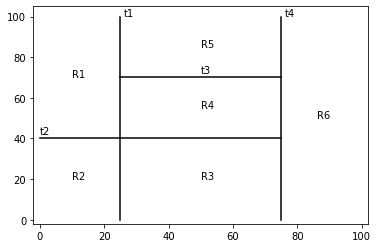

In [64]:
x1, y1 = [25, 25], [0, 100]
plt.plot(x1, y1, 'k')
matplotlib.pyplot.text(26, 100, 't1')
matplotlib.pyplot.text(10, 70, 'R1')

x2, y2 = [0, 75], [40, 40]
plt.plot(x2, y2,'k')
matplotlib.pyplot.text(0,42, 't2')
matplotlib.pyplot.text(10, 20, 'R2')

x3, y3 = [25, 75], [70, 70]
plt.plot(x3, y3,'k')
matplotlib.pyplot.text(50,72, 't3')
matplotlib.pyplot.text(50, 20, 'R3')

matplotlib.pyplot.text(50, 55, 'R4')
matplotlib.pyplot.text(50, 85, 'R5')

x4, y4 = [75, 75], [0,100]
plt.plot(x4, y4,'k')
matplotlib.pyplot.text(76,100, 't4')
matplotlib.pyplot.text(86, 50, 'R6')

plt.xlim([-2,102])
plt.ylim([-2,105])
plt.show()

###### **4.** In 2 dimensions, a linear decision boundary takes the form $\beta_0 + \beta_1 X_1 + \beta_2 X_2 = 0$. Consider a nn-linear decision boundary:

**a)** Sketch the curve

$$(1 + X_1)^2 + (2 - X_2)^2 = 4$$

Additionally, indicate on your sketch the set of points that verify the condition

$$(1 + X_1)^2 + (2 - X_2)^2 > 4$$

and the condition

$$(1 + X_1)^2 + (2 - X_2)^2 \leq 4$$

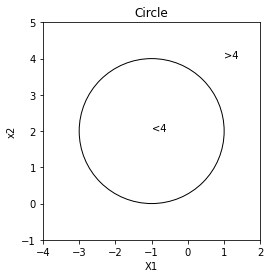

In [31]:
figure, axes = plt.subplots()
c

axes.set_aspect(1)
axes.add_artist(draw_circle)
plt.title('Circle')
plt.xlim([-4, 2])
plt.ylim([-1, 5])
plt.xlabel("X1")
plt.ylabel("x2")
matplotlib.pyplot.text(-1, 2, '<4')
matplotlib.pyplot.text(1,4 , '>4')
plt.show()

**b)** Suppose that a classifier assigns an observation to the blue class if $(1 + X_1)^2 + (2 - X_2)^2 > 4$ and to the red class otherwise. To what class are the following observations classified? (0,0), (-1,1), (2,2), (3,8)

Substituindo as coordenadas na equação obtemos que para (0,0) se obtém 5>4, logo é azul.
Com (-1,1) obtém-se 1>4, logo é vermelho.
Com (2,2) obtém-se 9>4, logo é azul.
Com (3,8) obtém-se 52>4, logo é azul.

**c)** Prove that while the decision boundary in (b) is not linear in terms of $X_1$ and $X_2$, it is linear in terms of $X_1$, $X_1^2$, $X_2$, and $X_2^2$.

Da equação:
(1+𝑋1)^2+(2−𝑋2)^2=4
ôbtém-se:
𝑋1^2 + 2*𝑋1 - 4*𝑋2 + 𝑋2^2 = -1
Que é linear em função de 𝑋1 , 𝑋1^2, 𝑋2, e 𝑋2^2.

# 4) Laboratory Questions

What are the advantages and disadvantages of relational dabases versus graph databases, and when should one type be preferred over the other?

A grande diferença entre ambas, é a forma como a relação entre as entidades é guardada. Nas "graph databases" as relações são guardadas em niveis de recorde individual, enquanto que na "relational databases" usa estruturas predefinidas, tais como tabelas.

As "relational databases" são mais rapidas, mesmo quando se lida com um grande valor de dados devido à estrutura dos dados que é conhecido antecipadamente, o que leva também, a uma pegada de memória menor. A estrutura tabular torna as "relational databases" uma boa opção para registos com relacionamentos descomplicados.

As "graph databases" tem ênfase nos relacionamentos, o que ajuda a explorar conjuntos de dados complexos. Dessa forma é possível encontrar conexões inesperadas entre os pontos de dados, tornando este método, a melhor opção para casos onde existe muitos relacionamentos. As relações de mapeamento também tornam as "graph databases" uma boa opção para visualizações de dados.